# 今回の取り組み

**Tyr10%でalbinoが検出されなかったので分類・クラスタリングの動作確認をする**

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [3]:
%%bash
# pipの更新
pip install -qU pip
pip install -qU -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.9 MB/s eta 0:00:00
  Attempting uninstall: pysam
    Found existing installation: pysam 0.20.0
    Uninstalling pysam-0.20.0:
      Successfully uninstalled pysam-0.20.0


# 実験

In [4]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, report
from DAJIN2.core.clustering import clustering

#### #* 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/tyr_albino_10%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "test-tyr-albino-10%",
    "mm10",
    True,
    14,
)
print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing test-tyr-albino-10%...


In [5]:

flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl").exists()
flag = flag1 and flag2

if not flag:
    print("preprocessing...")
    ################################################################################
    # Export fasta files as single-FASTA format
    ################################################################################
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    ###############################################################################
    # Mapping with mappy
    ###############################################################################
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    ########################################################################
    # MIDSV conversion
    ########################################################################
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    ###############################################################################
    # CSSPLITS Error Correction
    ###############################################################################
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    ###############################################################################
    # Convert any `N` as deletions other than consecutive `N` from both ends
    ###############################################################################
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    ###############################################################################
    # Cashe inputs (control)
    ###############################################################################
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


preprocessing...


In [6]:
MUTATION_LOCI = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

In [12]:
print(MUTATION_LOCI.keys())

dict_keys(['control'])

In [9]:
print(len(MUTATION_LOCI))
print(MUTATION_LOCI)

1
defaultdict(<class 'set'>, {'control': {828}})


In [10]:
########################################################################
# Classify alleles
########################################################################
print("Classify...")

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)


Classify...


In [11]:
classif_sample[0]

{'QNAME': '00065440-7084-4c4f-ada8-9eab3ba17263',
 'RNAME': 'control',
 'CSSPLIT': '=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=

In [12]:
####################################################################################
# Clustering
####################################################################################
print("Clustering...")

clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)

Clustering...


In [13]:
count_labels = defaultdict(int)
for clust in clust_sample:
    count_labels[clust["LABEL"]] += 1

print(count_labels)

defaultdict(<class 'int'>, {1: 9004, 2: 996})


⬆⬆⬆ あれっうまく行っている…？  

もういちどDAJIN2をCLIで動かしてみます。

In [14]:
%%bash
pip install -qe . &&
DAJIN2 \
    --name "test-tyr-albino-10%" \
    --sample "misc/data/tyr_albino_10%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome "mm10"

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_10%.fq.gz is now processing...
Finished! Open DAJINResults/test-tyr-albino-10% to see the report.


- とくになにも変更をせずとも、10%の変異を検出できました…？
  - batchモード特有の問題でしょうか…？
- もう一度 batchモードで行います
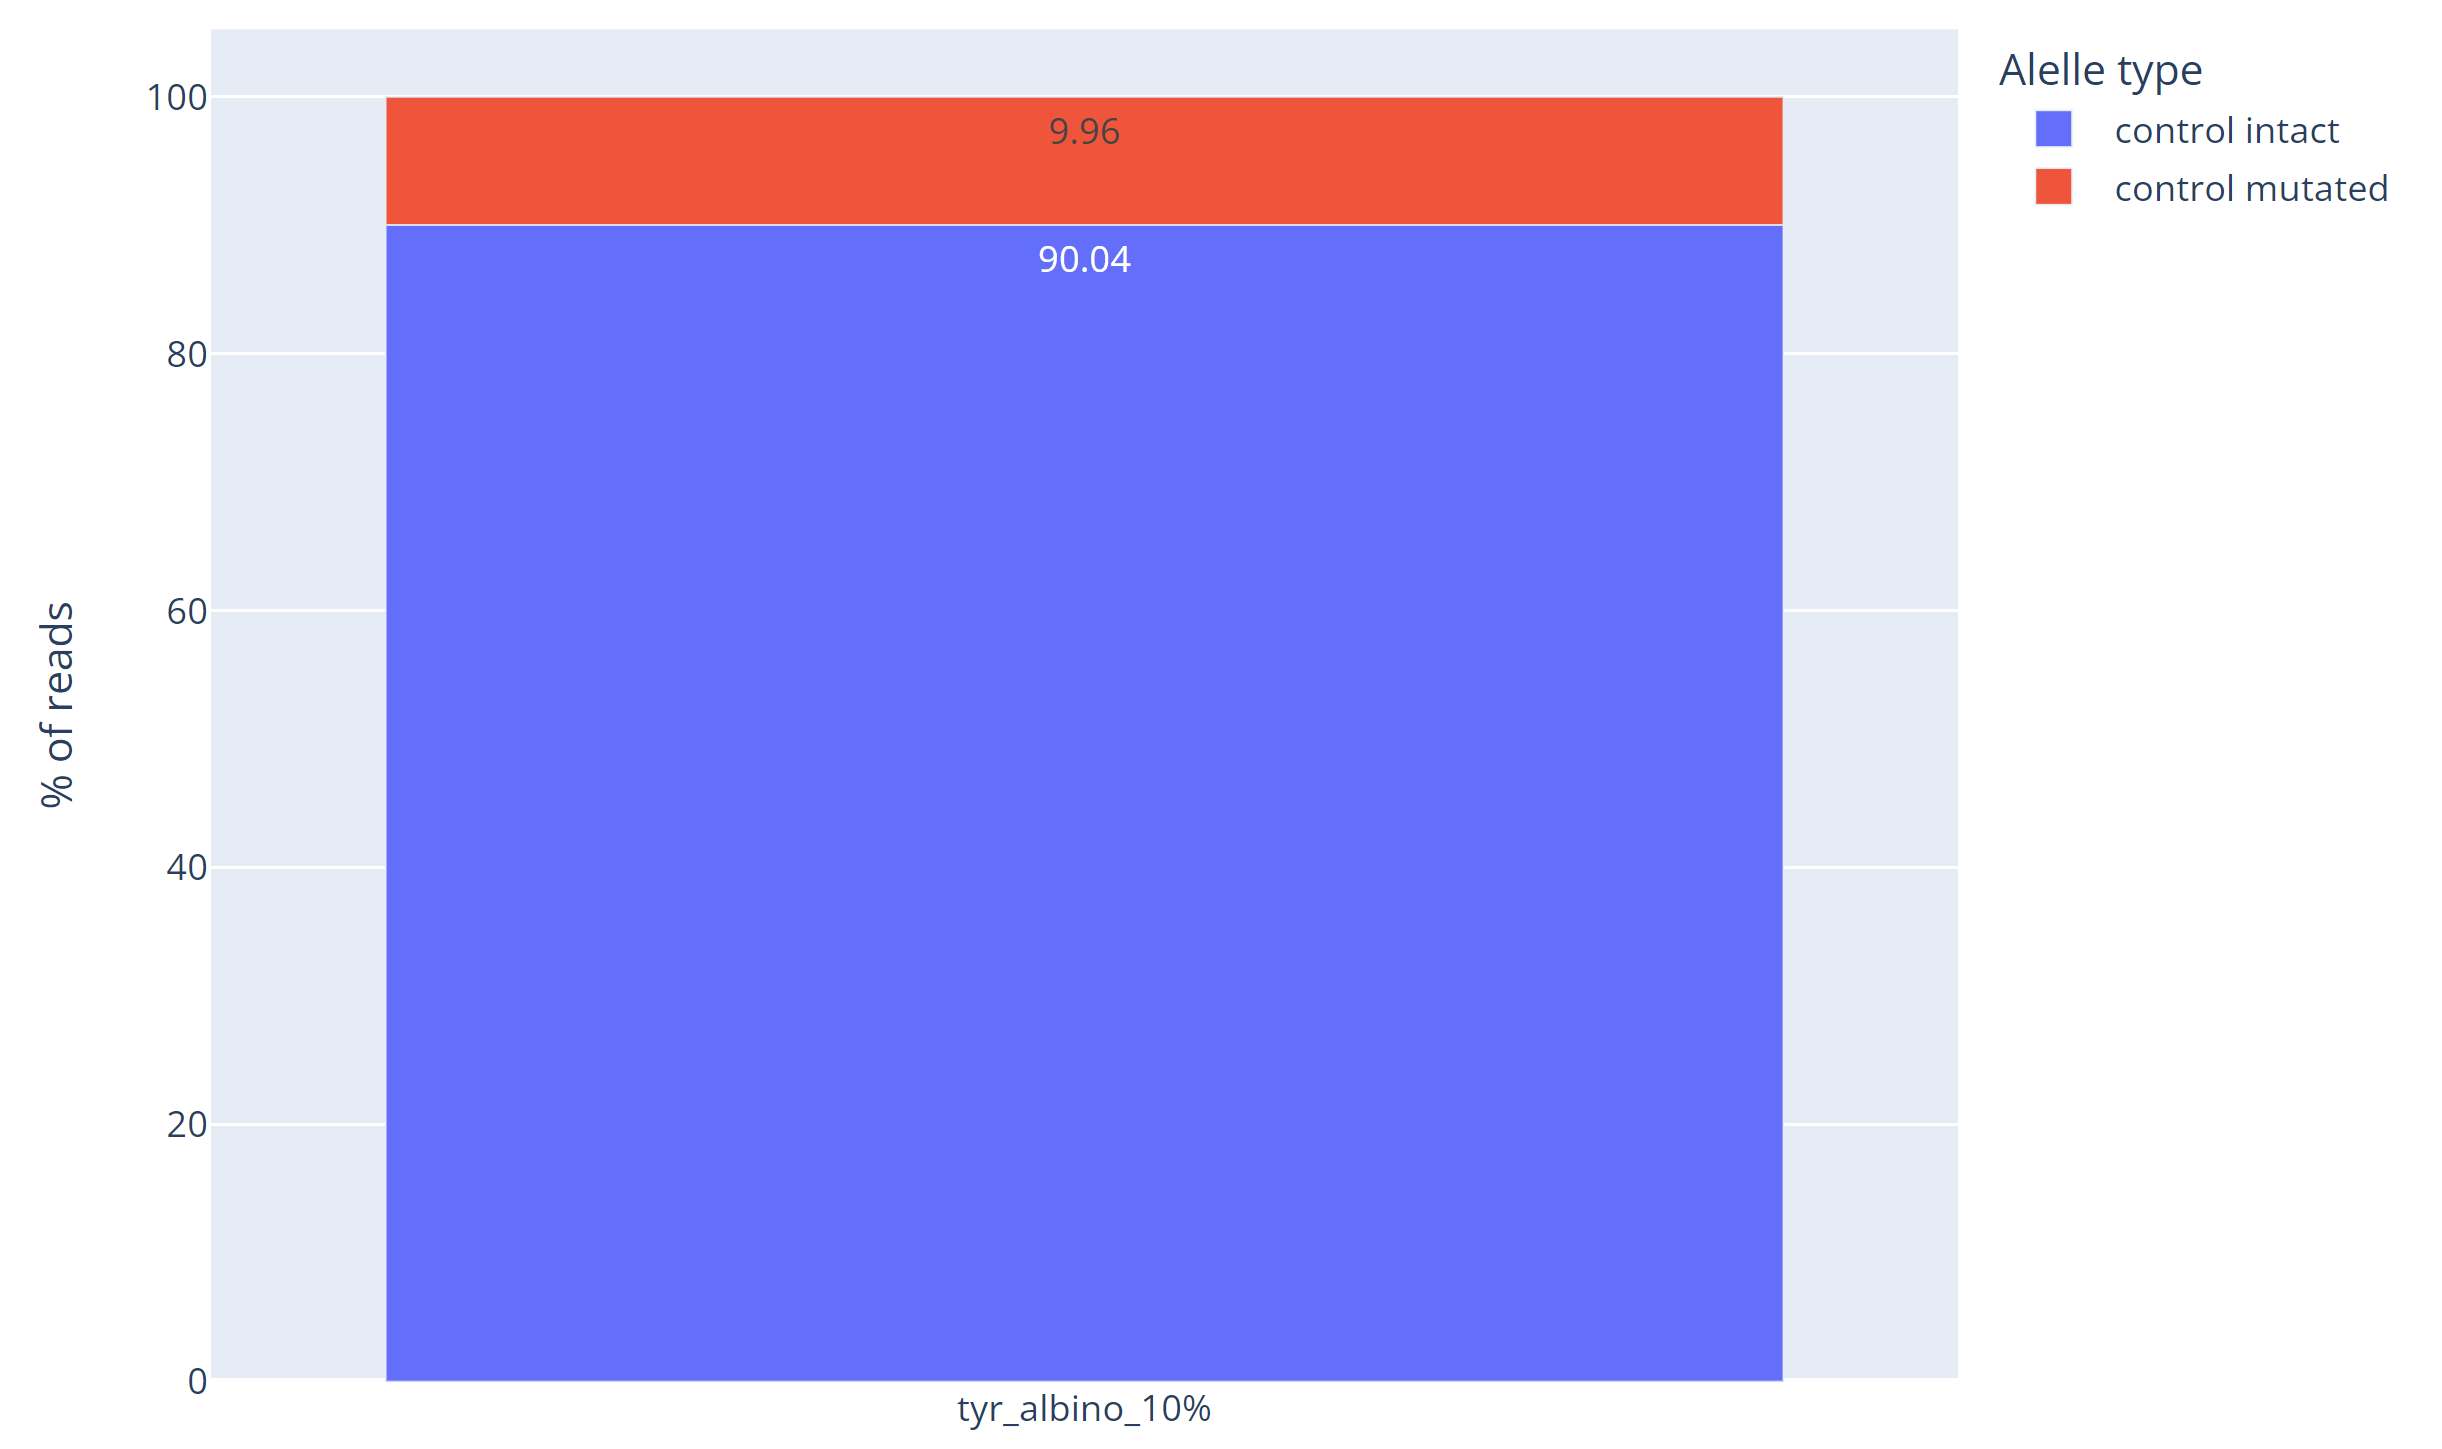

In [16]:
!rm -rf DAJINResults/tyr-batch DAJINResults/.tempdir/tyr-batch

In [17]:
%%bash
pip install -qe . && time DAJIN2 batch -f misc/data/design-dajin2.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...
misc/data/tyr_albino_10%.fq.gz is now processing...
misc/data/tyr_albino_01%.fq.gz is now processing...
Finished! Open DAJINResults/tyr-batch to see the report.

real	10m49.800s
user	13m7.252s
sys	9m31.115s


- なんとbatchモードにすると途端にうまくいかなくなりました…！

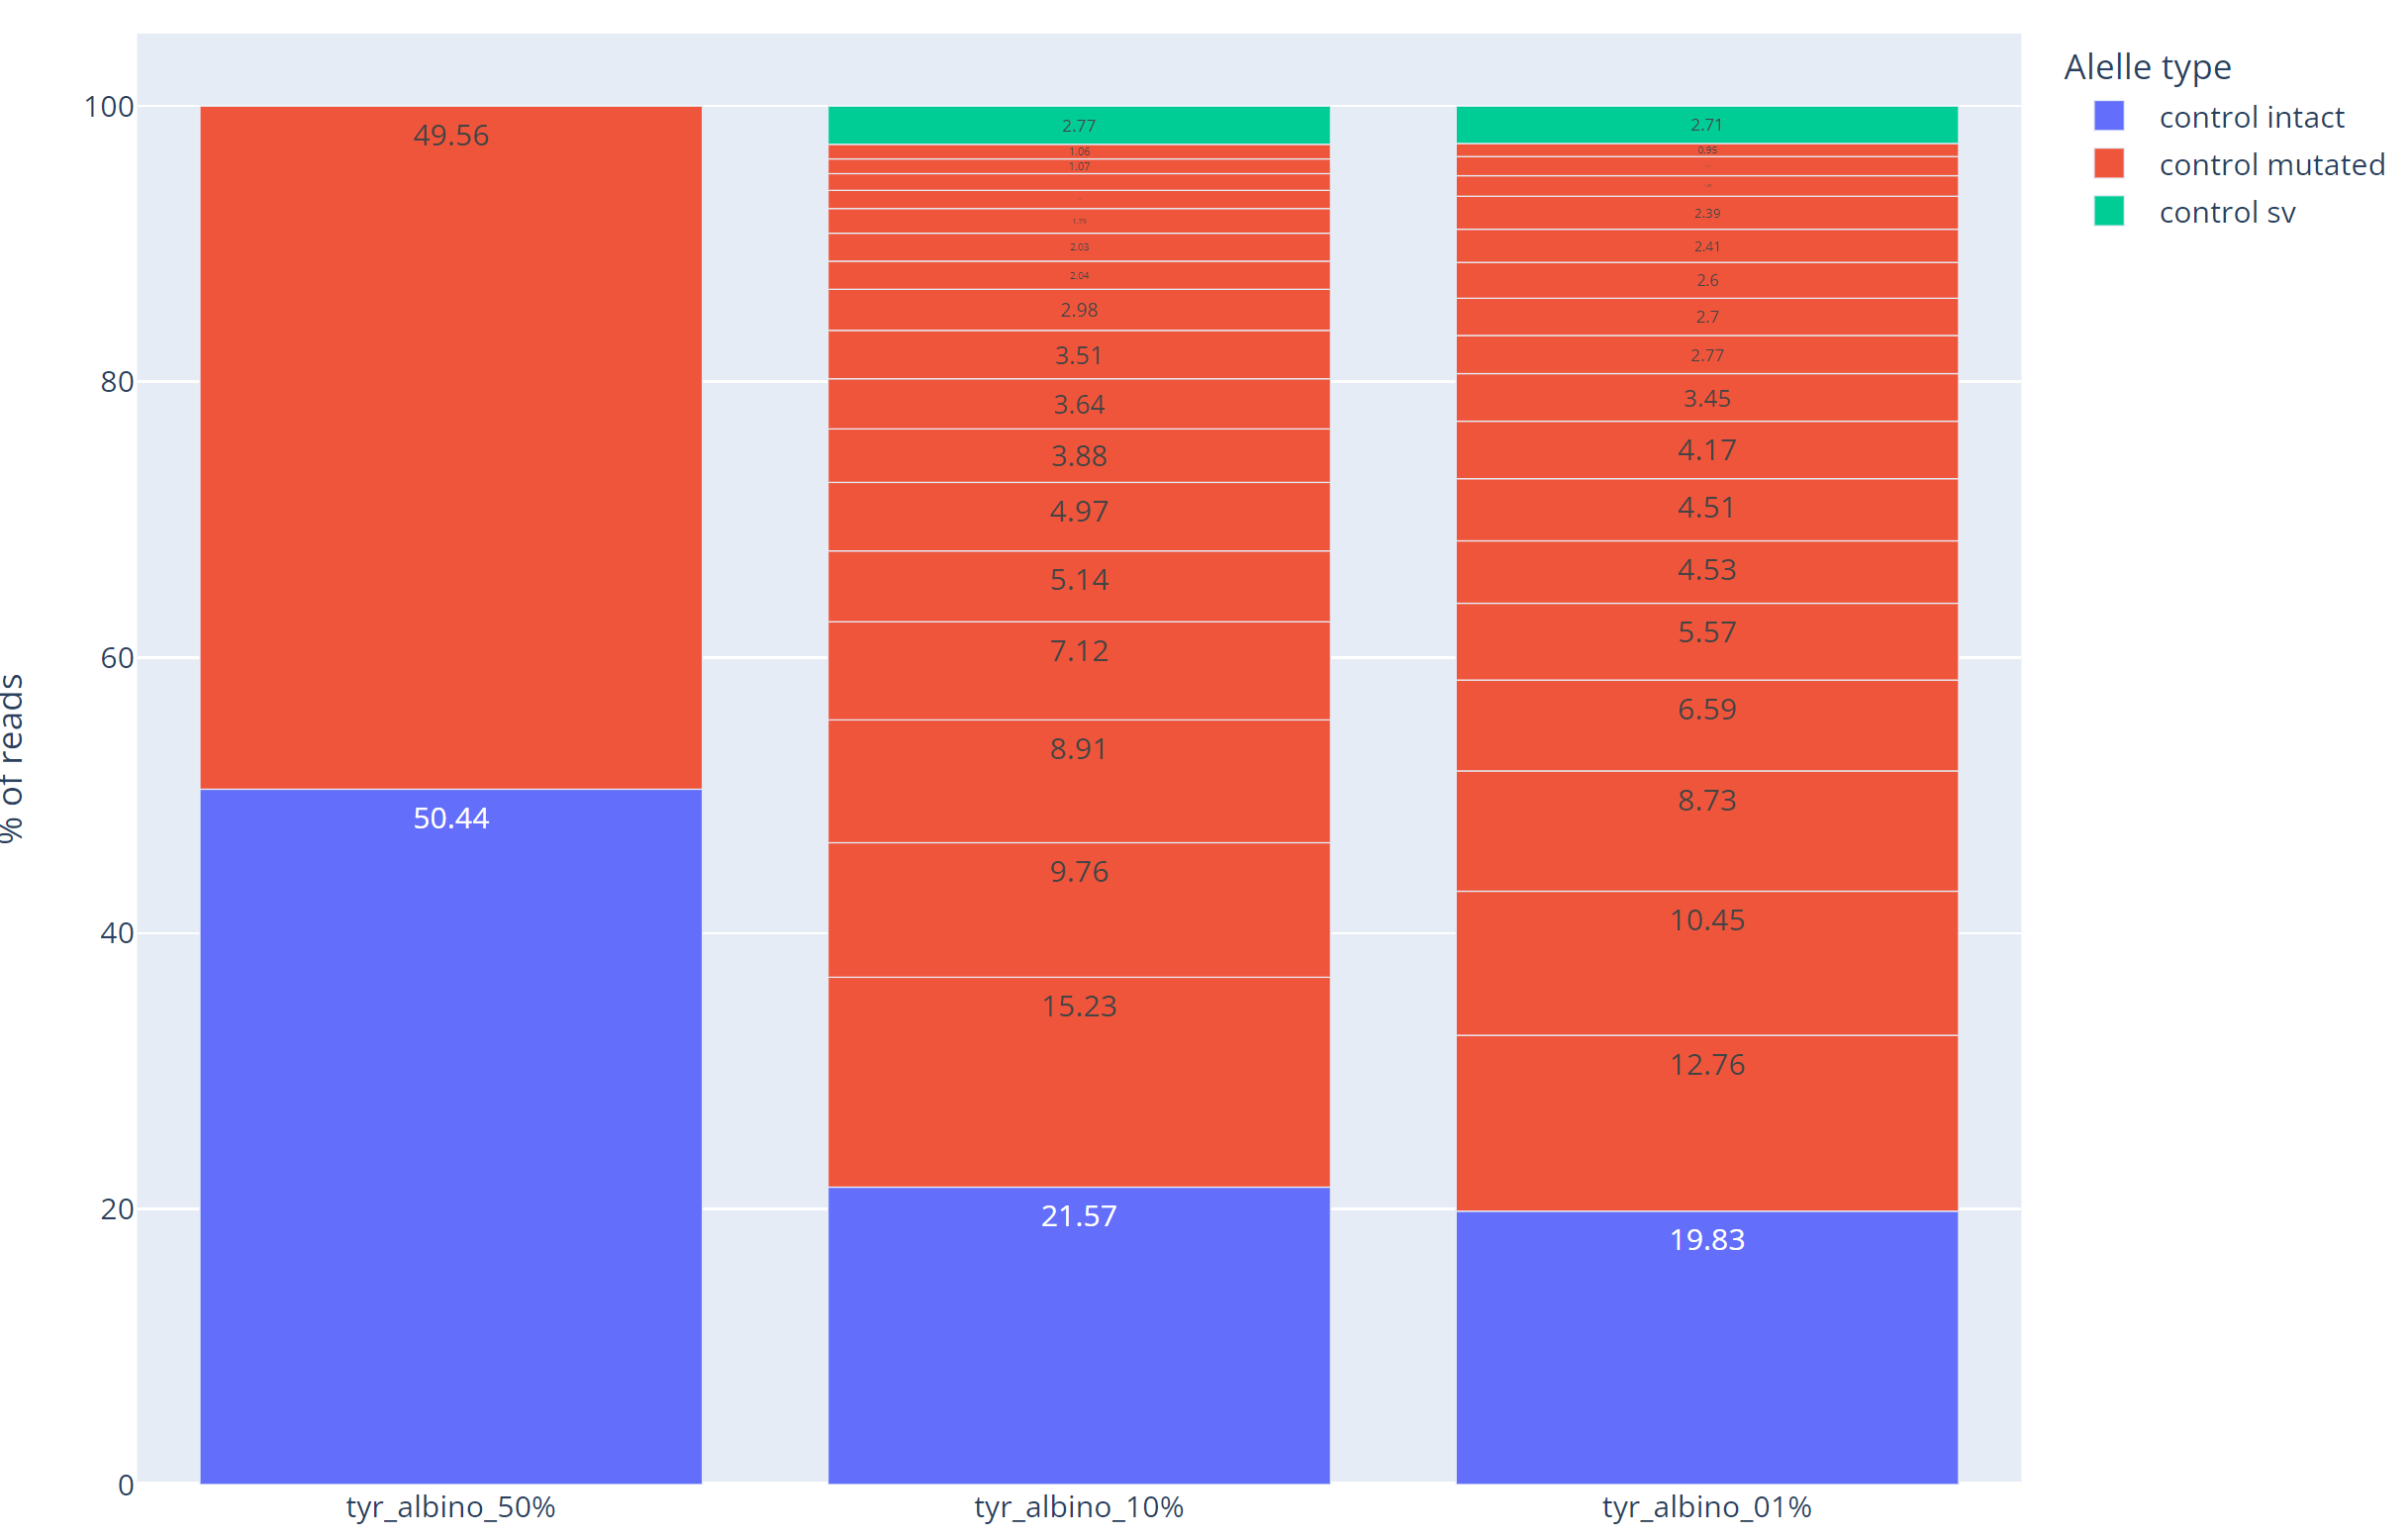

- コードをみると`core_execute.execute_sample`でSVの判定をしている箇所が`quickstart.py`と異なっていたので、quickstart.pyに合わせてリトライします。
  - core_executeはsingleモードと変わらないはずなので、ここに違いはないと思いますが…？

- 試しに50%をシングルモードで行い、Batchモードと違いがあるか見てみます。

In [26]:
%%bash
pip install -qe . &&
DAJIN2 \
    --name "test-tyr-albino-50%" \
    --sample "misc/data/tyr_albino_50%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome "mm10"

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/test-tyr-albino-50% to see the report.


- 50%はBatchもSingleも同じ結果でした。
- 逆に10%をBatchでやるとどうなるのでしょうか…


In [27]:
%%bash
cat misc/data/design-batch-tyr10%.csv

name,control,allele,genome,sample
tyr-batch-tyr10%,misc/data/tyr_control.fq.gz,misc/data/tyr_control.fasta,mm10,misc/data/tyr_albino_10%.fq.gz


In [28]:
%%bash
time DAJIN2 batch -f misc/data/design-batch-tyr10%.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/tyr-batch-tyr10% to see the report.

real	4m15.802s
user	3m52.878s
sys	0m55.767s


In [30]:
%%bash
diff DAJINResults/.tempdir/tyr-batch-tyr10%/midsv/tyr_albino_10%_splice_control.jsonl \
    DAJINResults/.tempdir/test-tyr-albino-10%/midsv/tyr_albino_10%_splice_control.jsonl |
    wc -l

0


- Batchを10%**だけ**で行うと、SingleとBatchで同じ結果となりました
- Batchがなにか悪さをしています…！

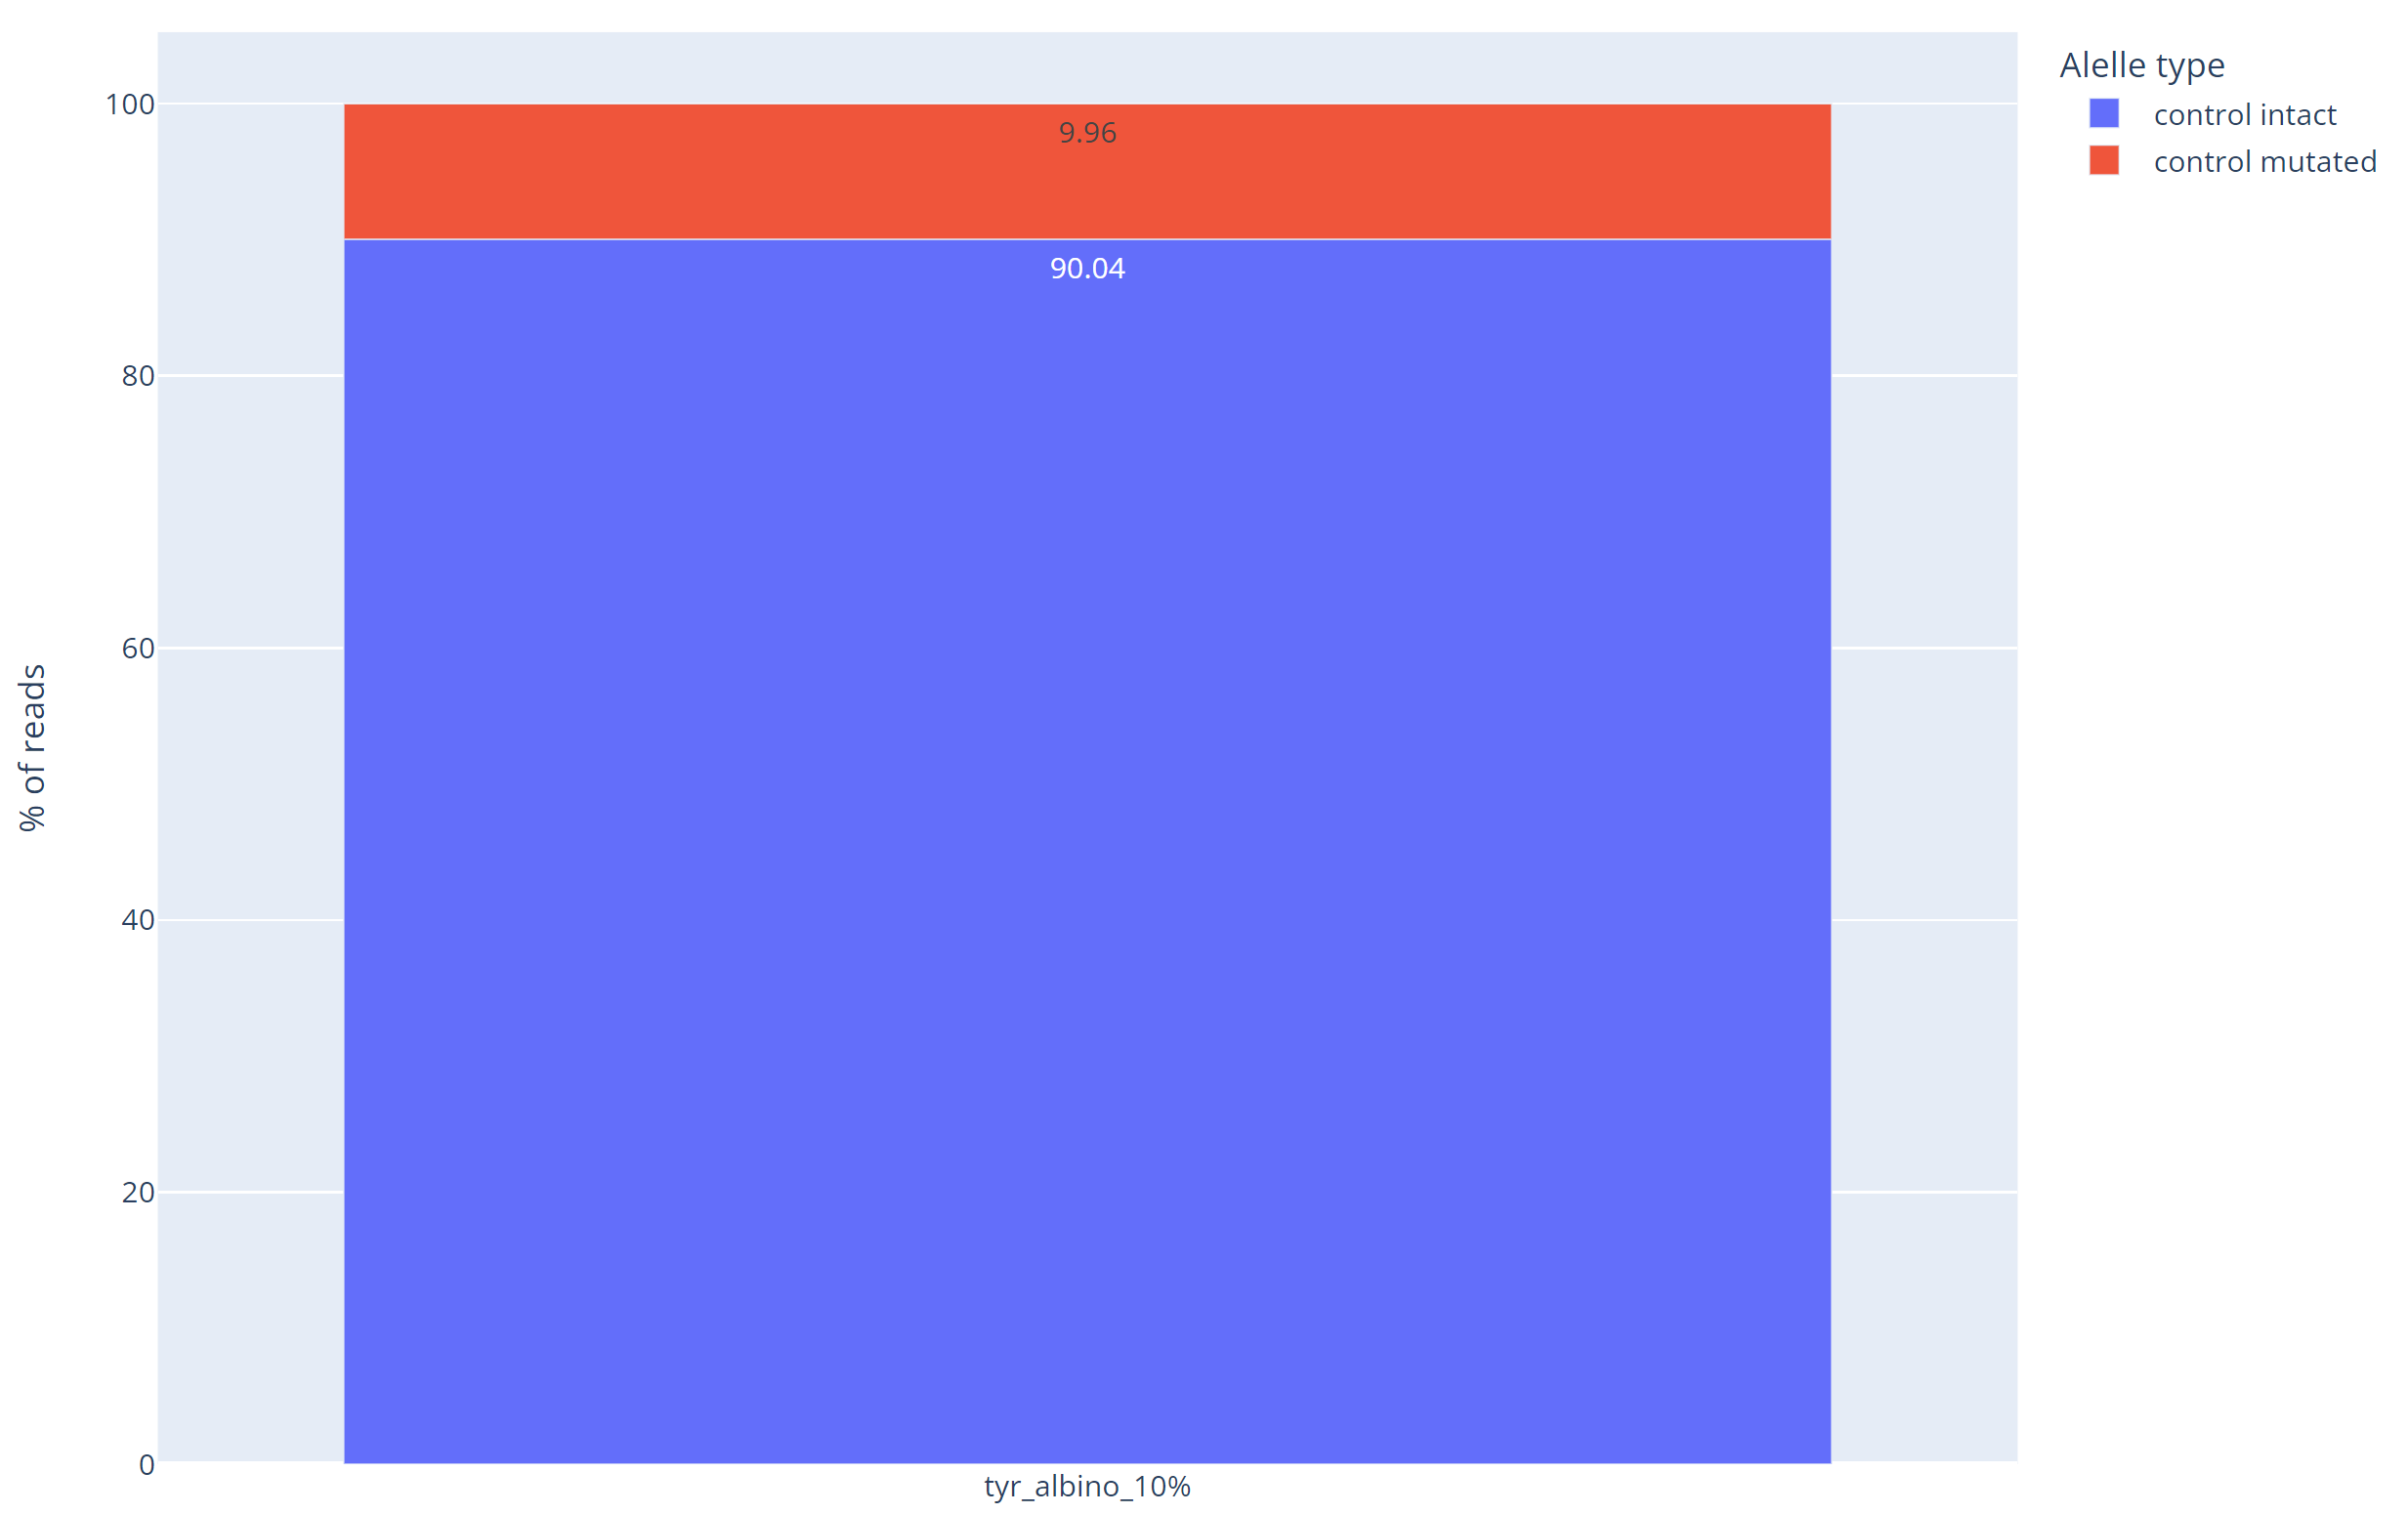

- batchにおいて、50%と10%の2つで試してみます。


In [31]:
%%bash
time DAJIN2 batch -f misc/data/design-batch-tyr-10-50.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/tyr-batch-10-50 to see the report.

real	6m59.673s
user	8m27.247s
sys	6m6.242s


In [32]:
%%bash
diff DAJINResults/.tempdir/tyr-batch-10-50/midsv/tyr_albino_10%_splice_control.jsonl \
    DAJINResults/.tempdir/test-tyr-albino-10%/midsv/tyr_albino_10%_splice_control.jsonl |
    wc -l

19988


やっぱりBatch処理だとうまくいかなくなるみたいです…

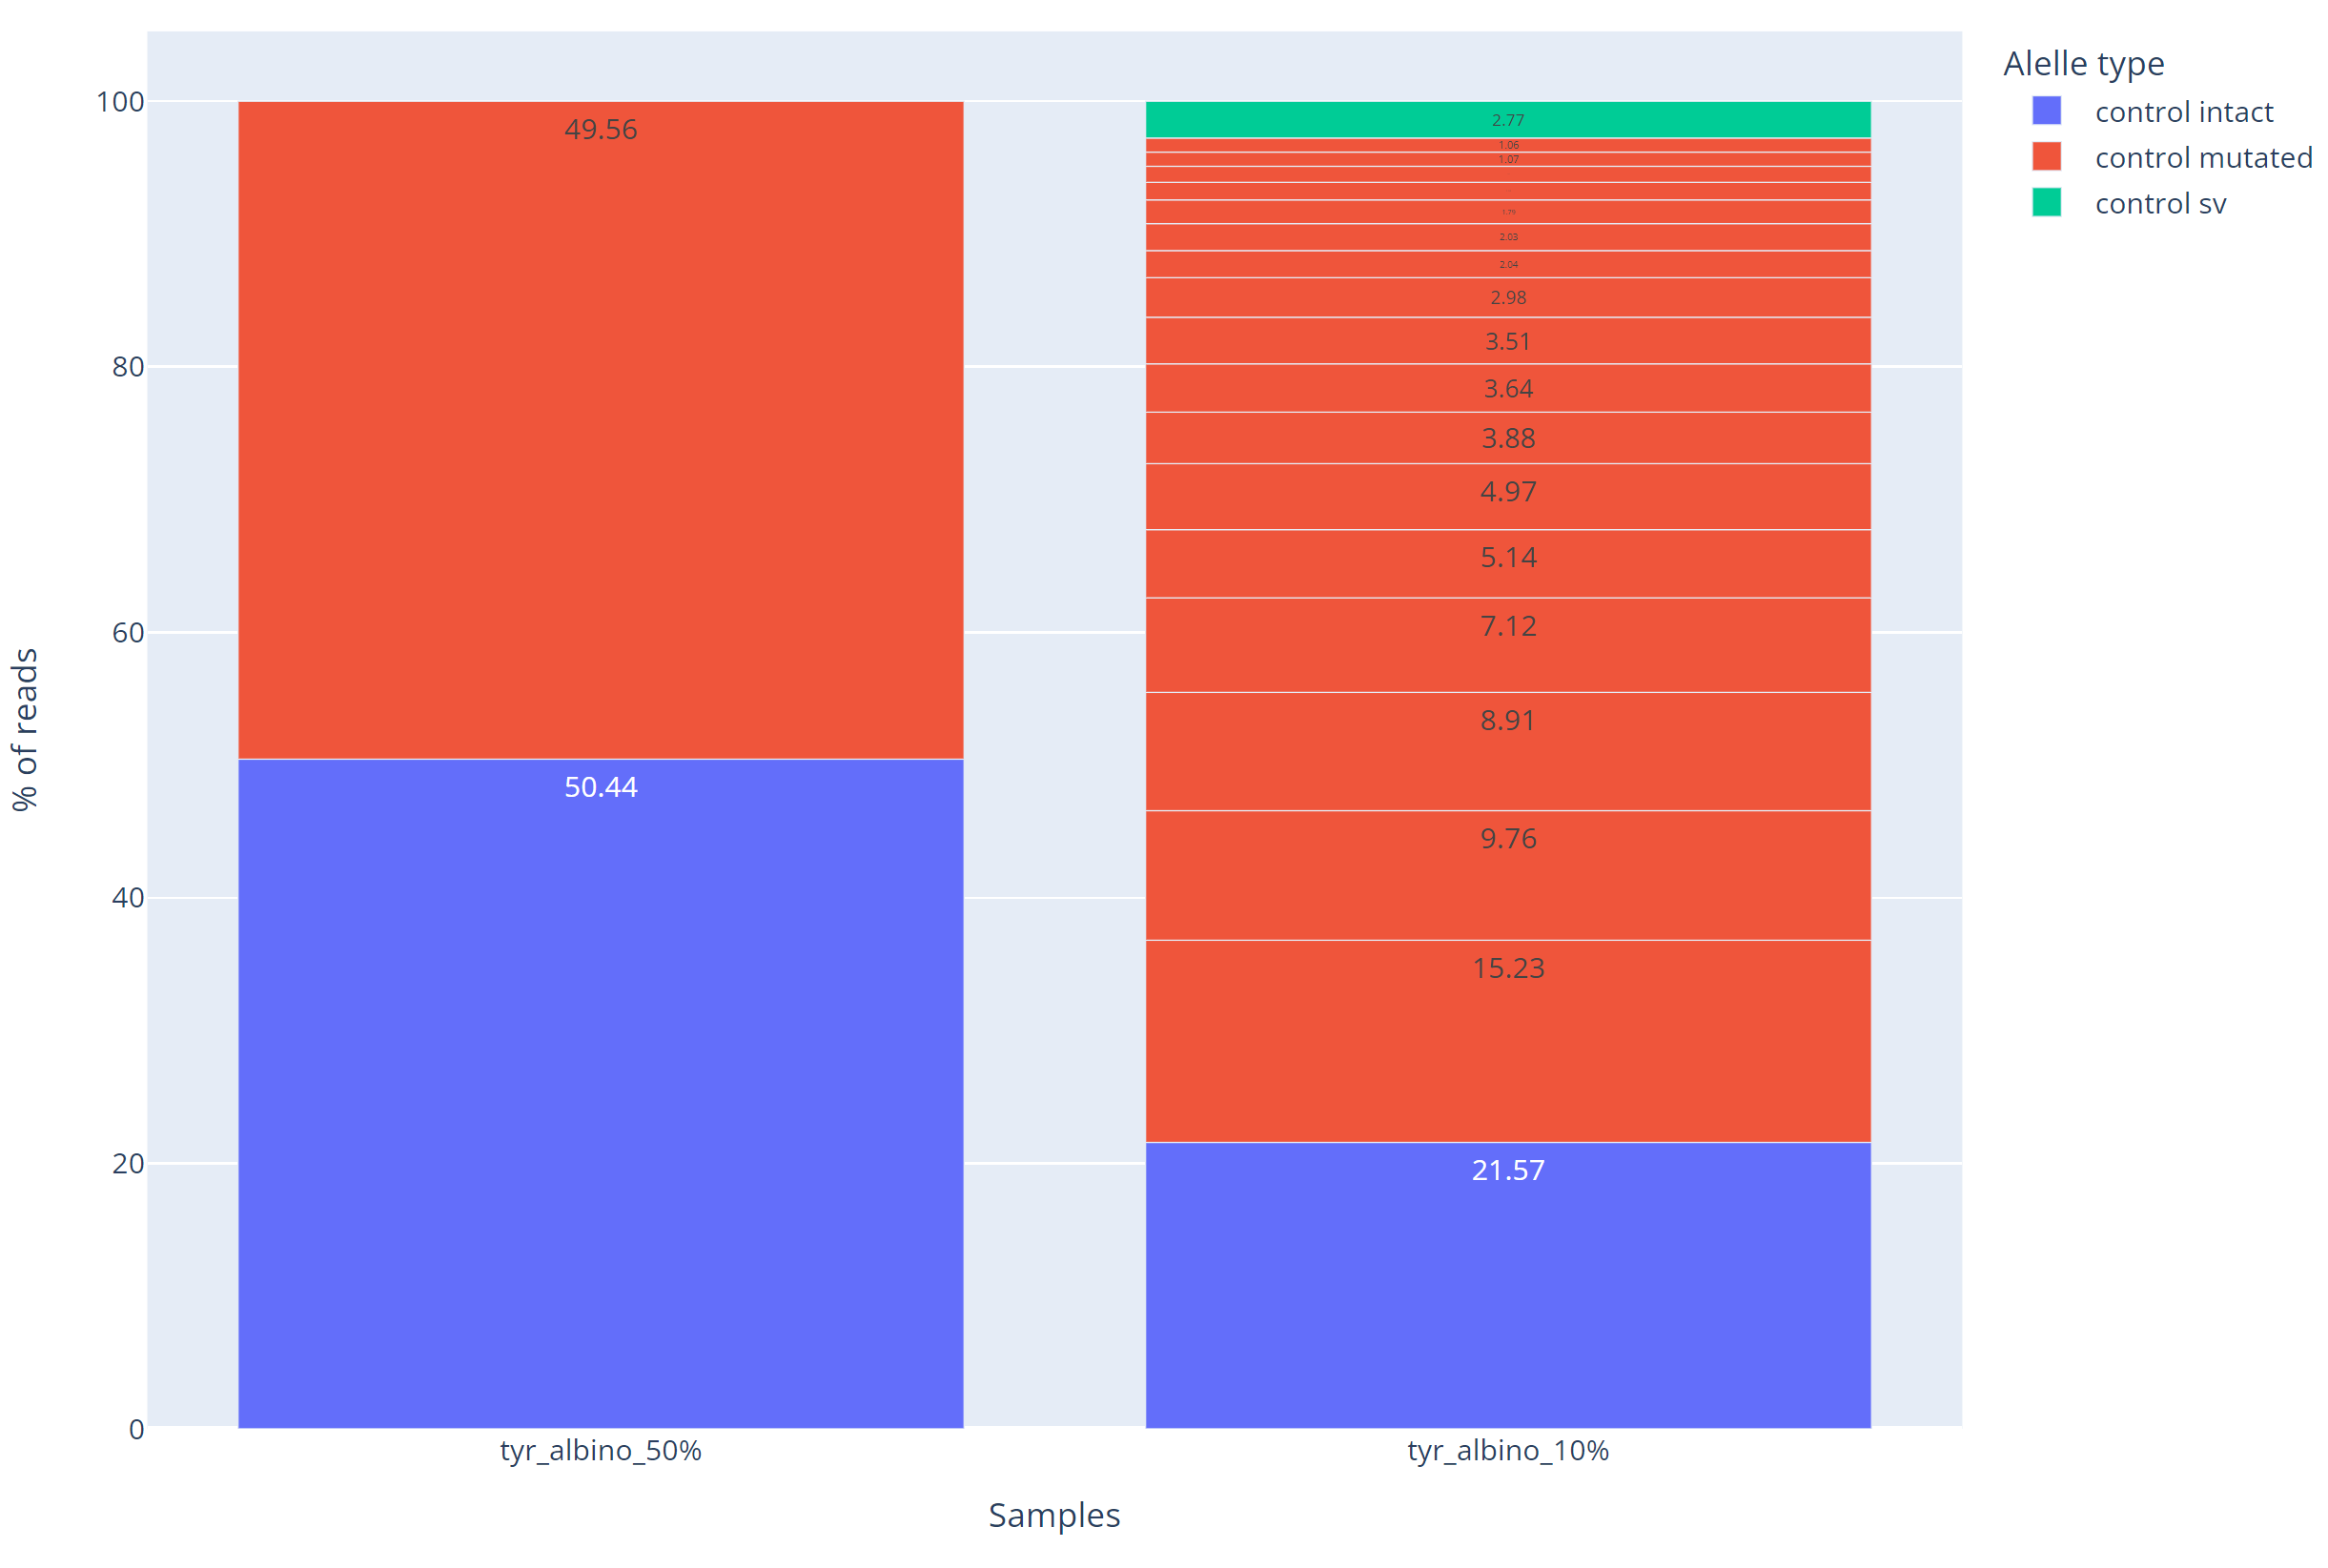

ちなみに、Batchファイルの10%と50%を反対にするとどうなるでしょうか

In [37]:
%%bash
cat misc/data/design-batch-tyr-10-50.csv

name,control,allele,genome,sample
tyr-batch-10-50,misc/data/tyr_control.fq.gz,misc/data/tyr_control.fasta,mm10,misc/data/tyr_albino_10%.fq.gz
tyr-batch-10-50,misc/data/tyr_control.fq.gz,misc/data/tyr_control.fasta,mm10,misc/data/tyr_albino_50%.fq.gz


In [39]:
%%bash
time DAJIN2 batch -f misc/data/design-batch-tyr-10-50.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/tyr-batch-10-50 to see the report.

real	6m46.057s
user	7m20.274s
sys	4m22.278s


- 想定通り、はじめの1回（今回はTyr-10%）しかうまくいきませんでした。
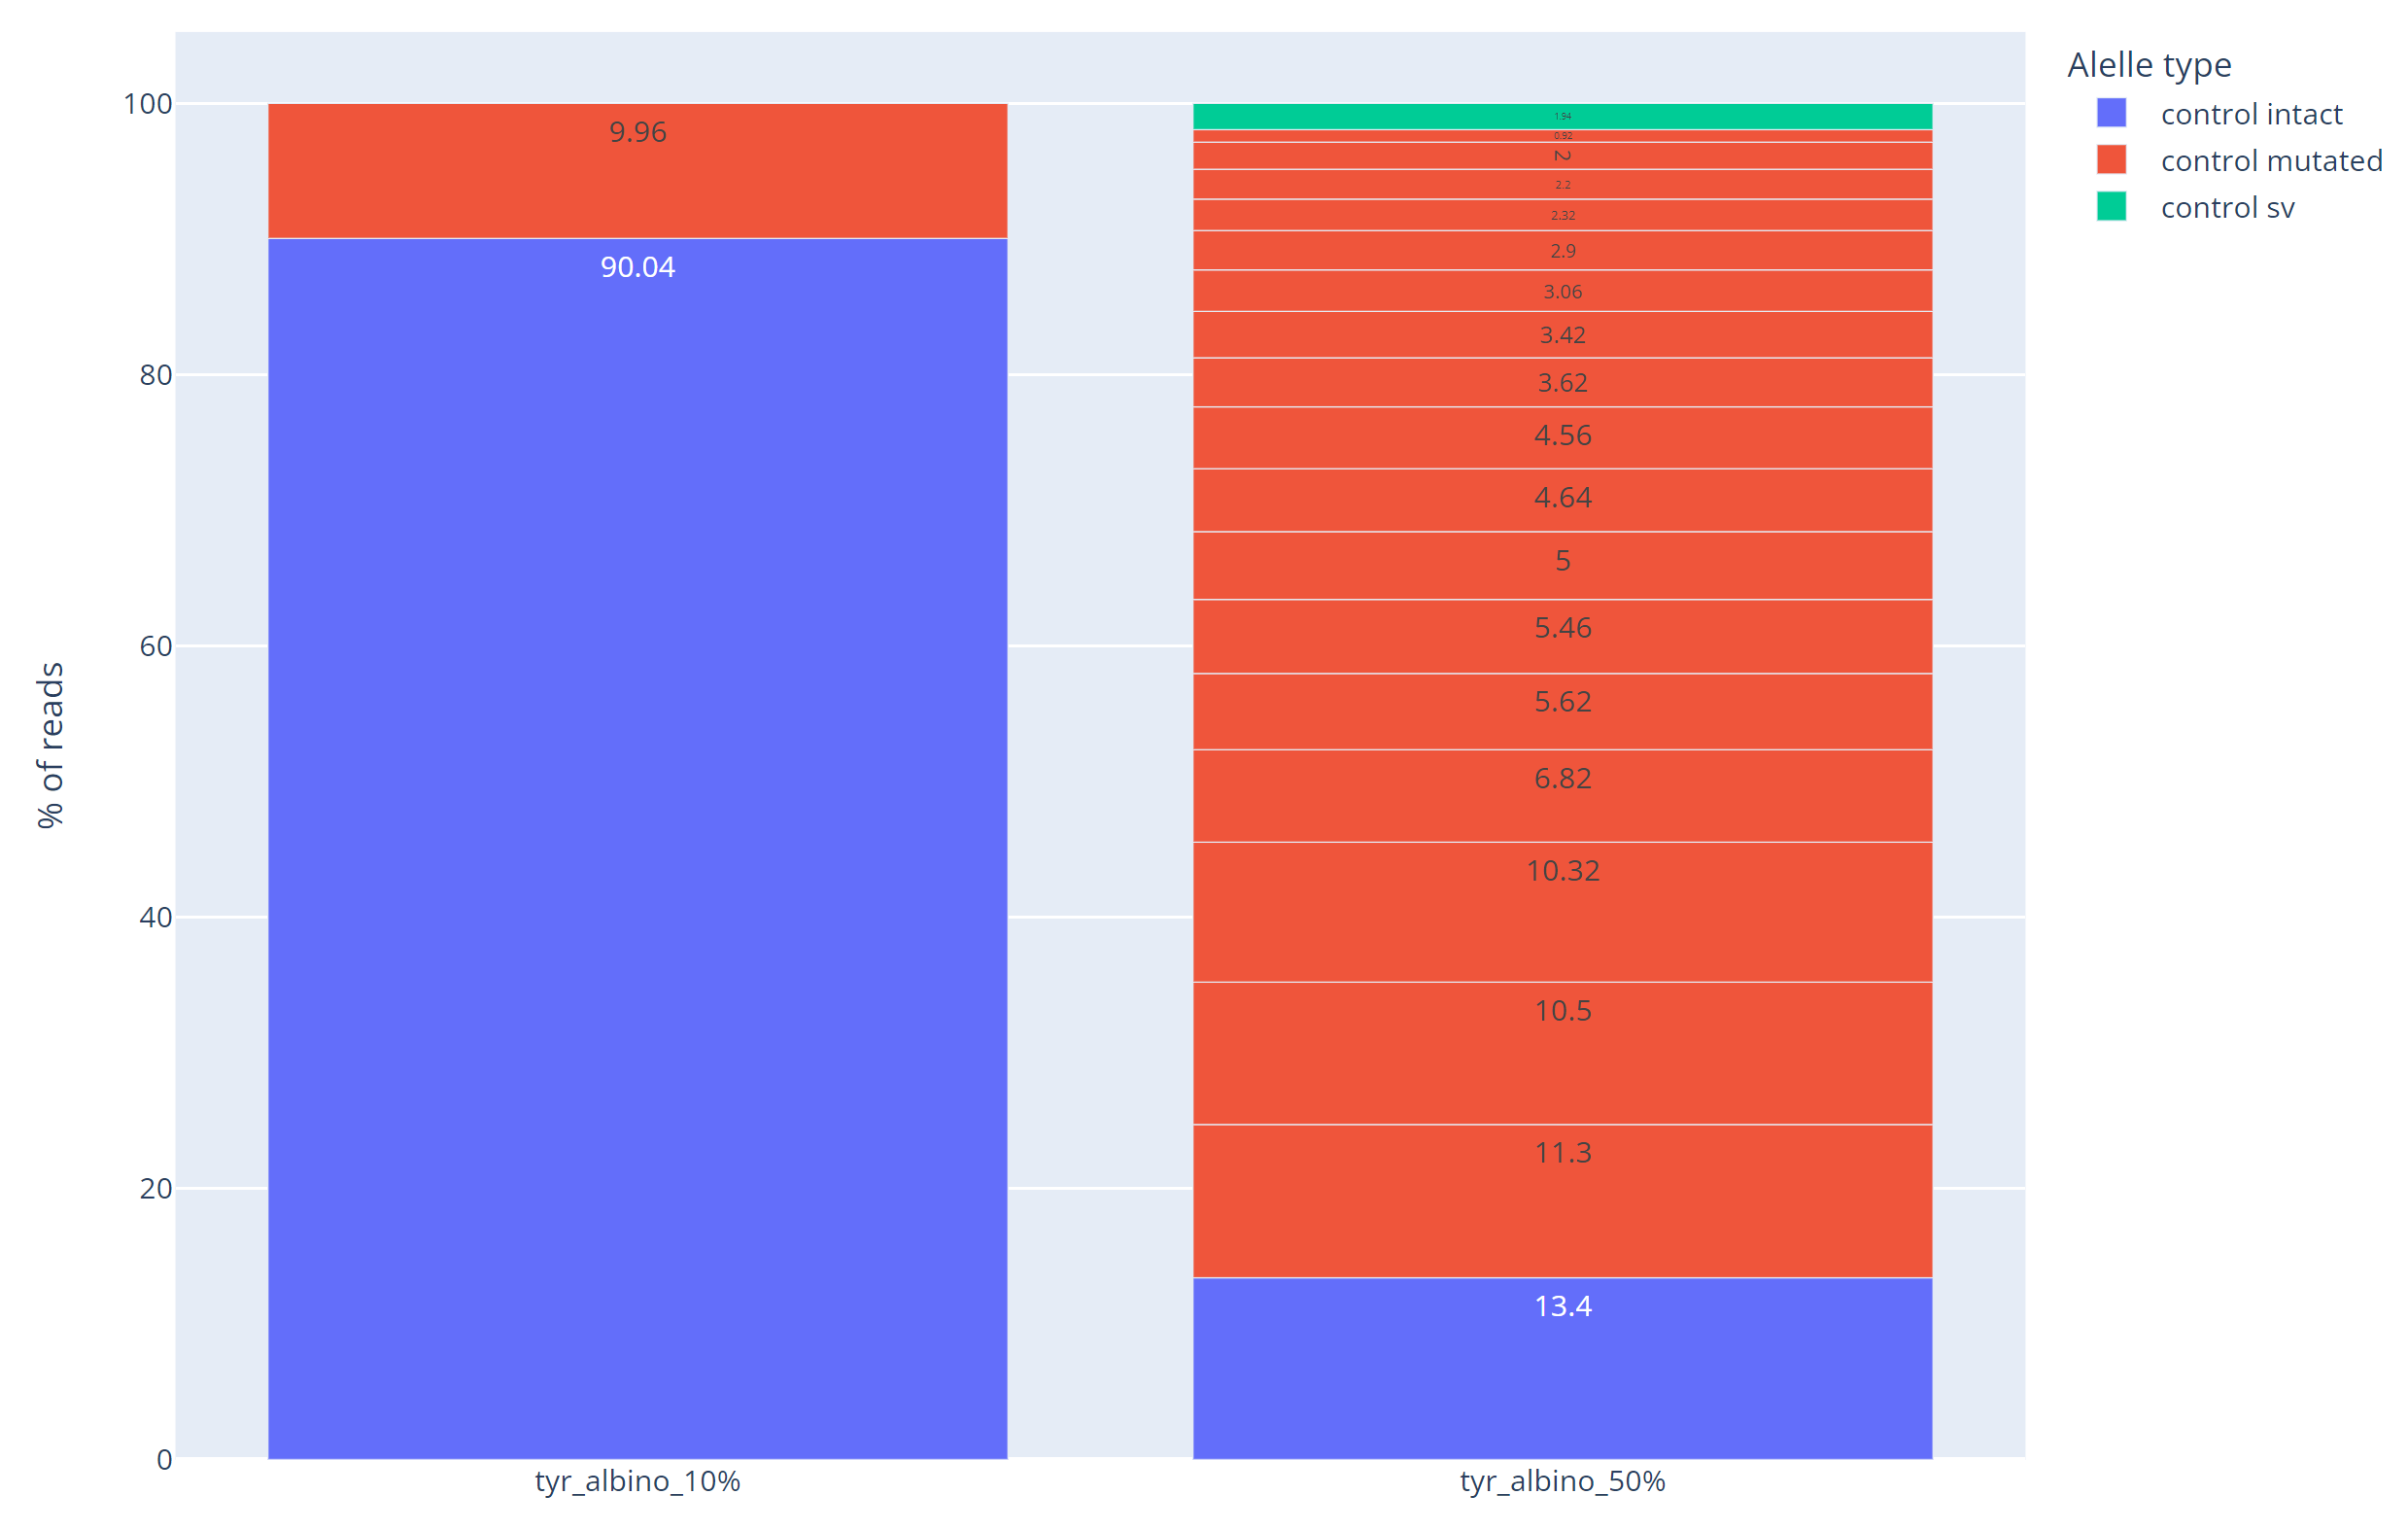

- Batch処理のどこかで、処理後のファイルを読み込んでしまっているようです


なんとなくpreprocess.corecct_sequence_errorらへんが怪しい感じがするので、いったん`preprocess.call_midsv`で打ち切って、うまく行ったときとおなじMIDSVが出力されているかを観察します

In [44]:
%%bash
pip install -qe .
rm -rf DAJINResults/.tempdir/tyr-albino*

DAJIN2 \
    --name "tyr_albino_50" \
    --sample "misc/data/tyr_albino_50%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome "mm10"

DAJIN2 \
    --name "tyr_albino_10" \
    --sample "misc/data/tyr_albino_10%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome "mm10"

misc/data/tyr_control.fq.gz is now processing...
Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 94, in main
    single.single_execute(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/single.py", line 12, in single_execute
    core_execute.execute_sample(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 106, in execute_sample
    preprocess.call_midsv(TEMPDIR, path_sam)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/preprocess/call_midsv.py", line 10, in call_midsv
    midsv.write_jsonl(midsv_jsonl, output_jsonl)
  File "/home/kuno/miniconda/lib/python3.10/site-packages/midsv/io.py", line 30, in write_jsonl
    with open(filepath, "w") as output:
FileNotFoundError: [Errno 2] No such file or directory: 'DAJINResults/.tempdir/tyr-albino-50%/midsv/tyr_albino_50%_splice_control

CalledProcessError: Command 'b'pip install -qe .\nrm -rf DAJINResults/.tempdir/tyr-albino*\n\nDAJIN2 \\\n    --name "tyr_albino_50" \\\n    --sample "misc/data/tyr_albino_50%.fq.gz" \\\n    --control "misc/data/tyr_control.fq.gz" \\\n    --allele "misc/data/tyr_control.fasta" \\\n    --genome "mm10"\n\nDAJIN2 \\\n    --name "tyr_albino_10" \\\n    --sample "misc/data/tyr_albino_10%.fq.gz" \\\n    --control "misc/data/tyr_control.fq.gz" \\\n    --allele "misc/data/tyr_control.fasta" \\\n    --genome "mm10"\n'' returned non-zero exit status 1.

In [45]:
%%bash
rm -rf DAJINResults/tyr_batch_10_50 DAJINResults/.tempdir/tyr_batch10_50
time DAJIN2 batch -f misc/data/design_batch_tyr_10_50.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_10%.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...
Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 74, in main
    args.handler(args)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 37, in batchmode
    batch.batch_execute(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/batch.py", line 78, in batch_execute
    report.report(name)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/postprocess/report.py", line 60, in report
    df_summary = summary_info(df_all)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/postprocess/report.py", line 25, in summary_info
    df_summary = df_all.drop(columns=["QNAME", "LABEL", "ALLELE", "SV"]).drop_duplicates()
  File "/home/kuno/miniconda/lib/python3.10/site-packages/pandas

CalledProcessError: Command 'b'rm -rf DAJINResults/tyr_batch_10_50 DAJINResults/.tempdir/tyr_batch10_50\ntime DAJIN2 batch -f misc/data/design_batch_tyr_10_50.csv\n'' returned non-zero exit status 1.

In [46]:
%%bash
# 10%
diff DAJINResults/.tempdir/tyr_batch_10_50/midsv/tyr_albino_10%_splice_control.jsonl \
    DAJINResults/.tempdir/tyr_albino_10/midsv/tyr_albino_10%_splice_control.jsonl

In [47]:
%%bash
# 50%
diff DAJINResults/.tempdir/tyr_batch_10_50/midsv/tyr_albino_50%_splice_control.jsonl \
    DAJINResults/.tempdir/tyr_albino_50/midsv/tyr_albino_50%_splice_control.jsonl

- `preprocess.call_midsv`までは大丈夫そうです

- おそらく、`preprocess.correct_sequence_error`でcontrolが上書きされているので、これが2回目以降に呼び出されて悪さをしているように思います。
- 上書きをやめるのが良さそうです。

- tempdirに作られるディレクトリに`midsv_control`を加えました
- controlのMIDSVはこのディレクトリにコピーします
- sampleの実行時にcontrolのMIDSVをこのディレクトリからmidsvにコピーするようにしました
- つまり`midsv_control`にオリジナル版を入れておいて、各サンプルの実行時はオリジナルをコピーして使用する、といった形にしました

In [54]:
%%bash
# さっそくテスト…
rm -rf DAJINResults/tyr_batch_10_50 DAJINResults/.tempdir/tyr_batch10_50
time DAJIN2 batch -f misc/data/design_batch_tyr_10_50.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/tyr_batch_10_50 to see the report.

real	7m1.707s
user	6m4.047s
sys	1m34.194s


- 来ました！！🎉🎉🎉

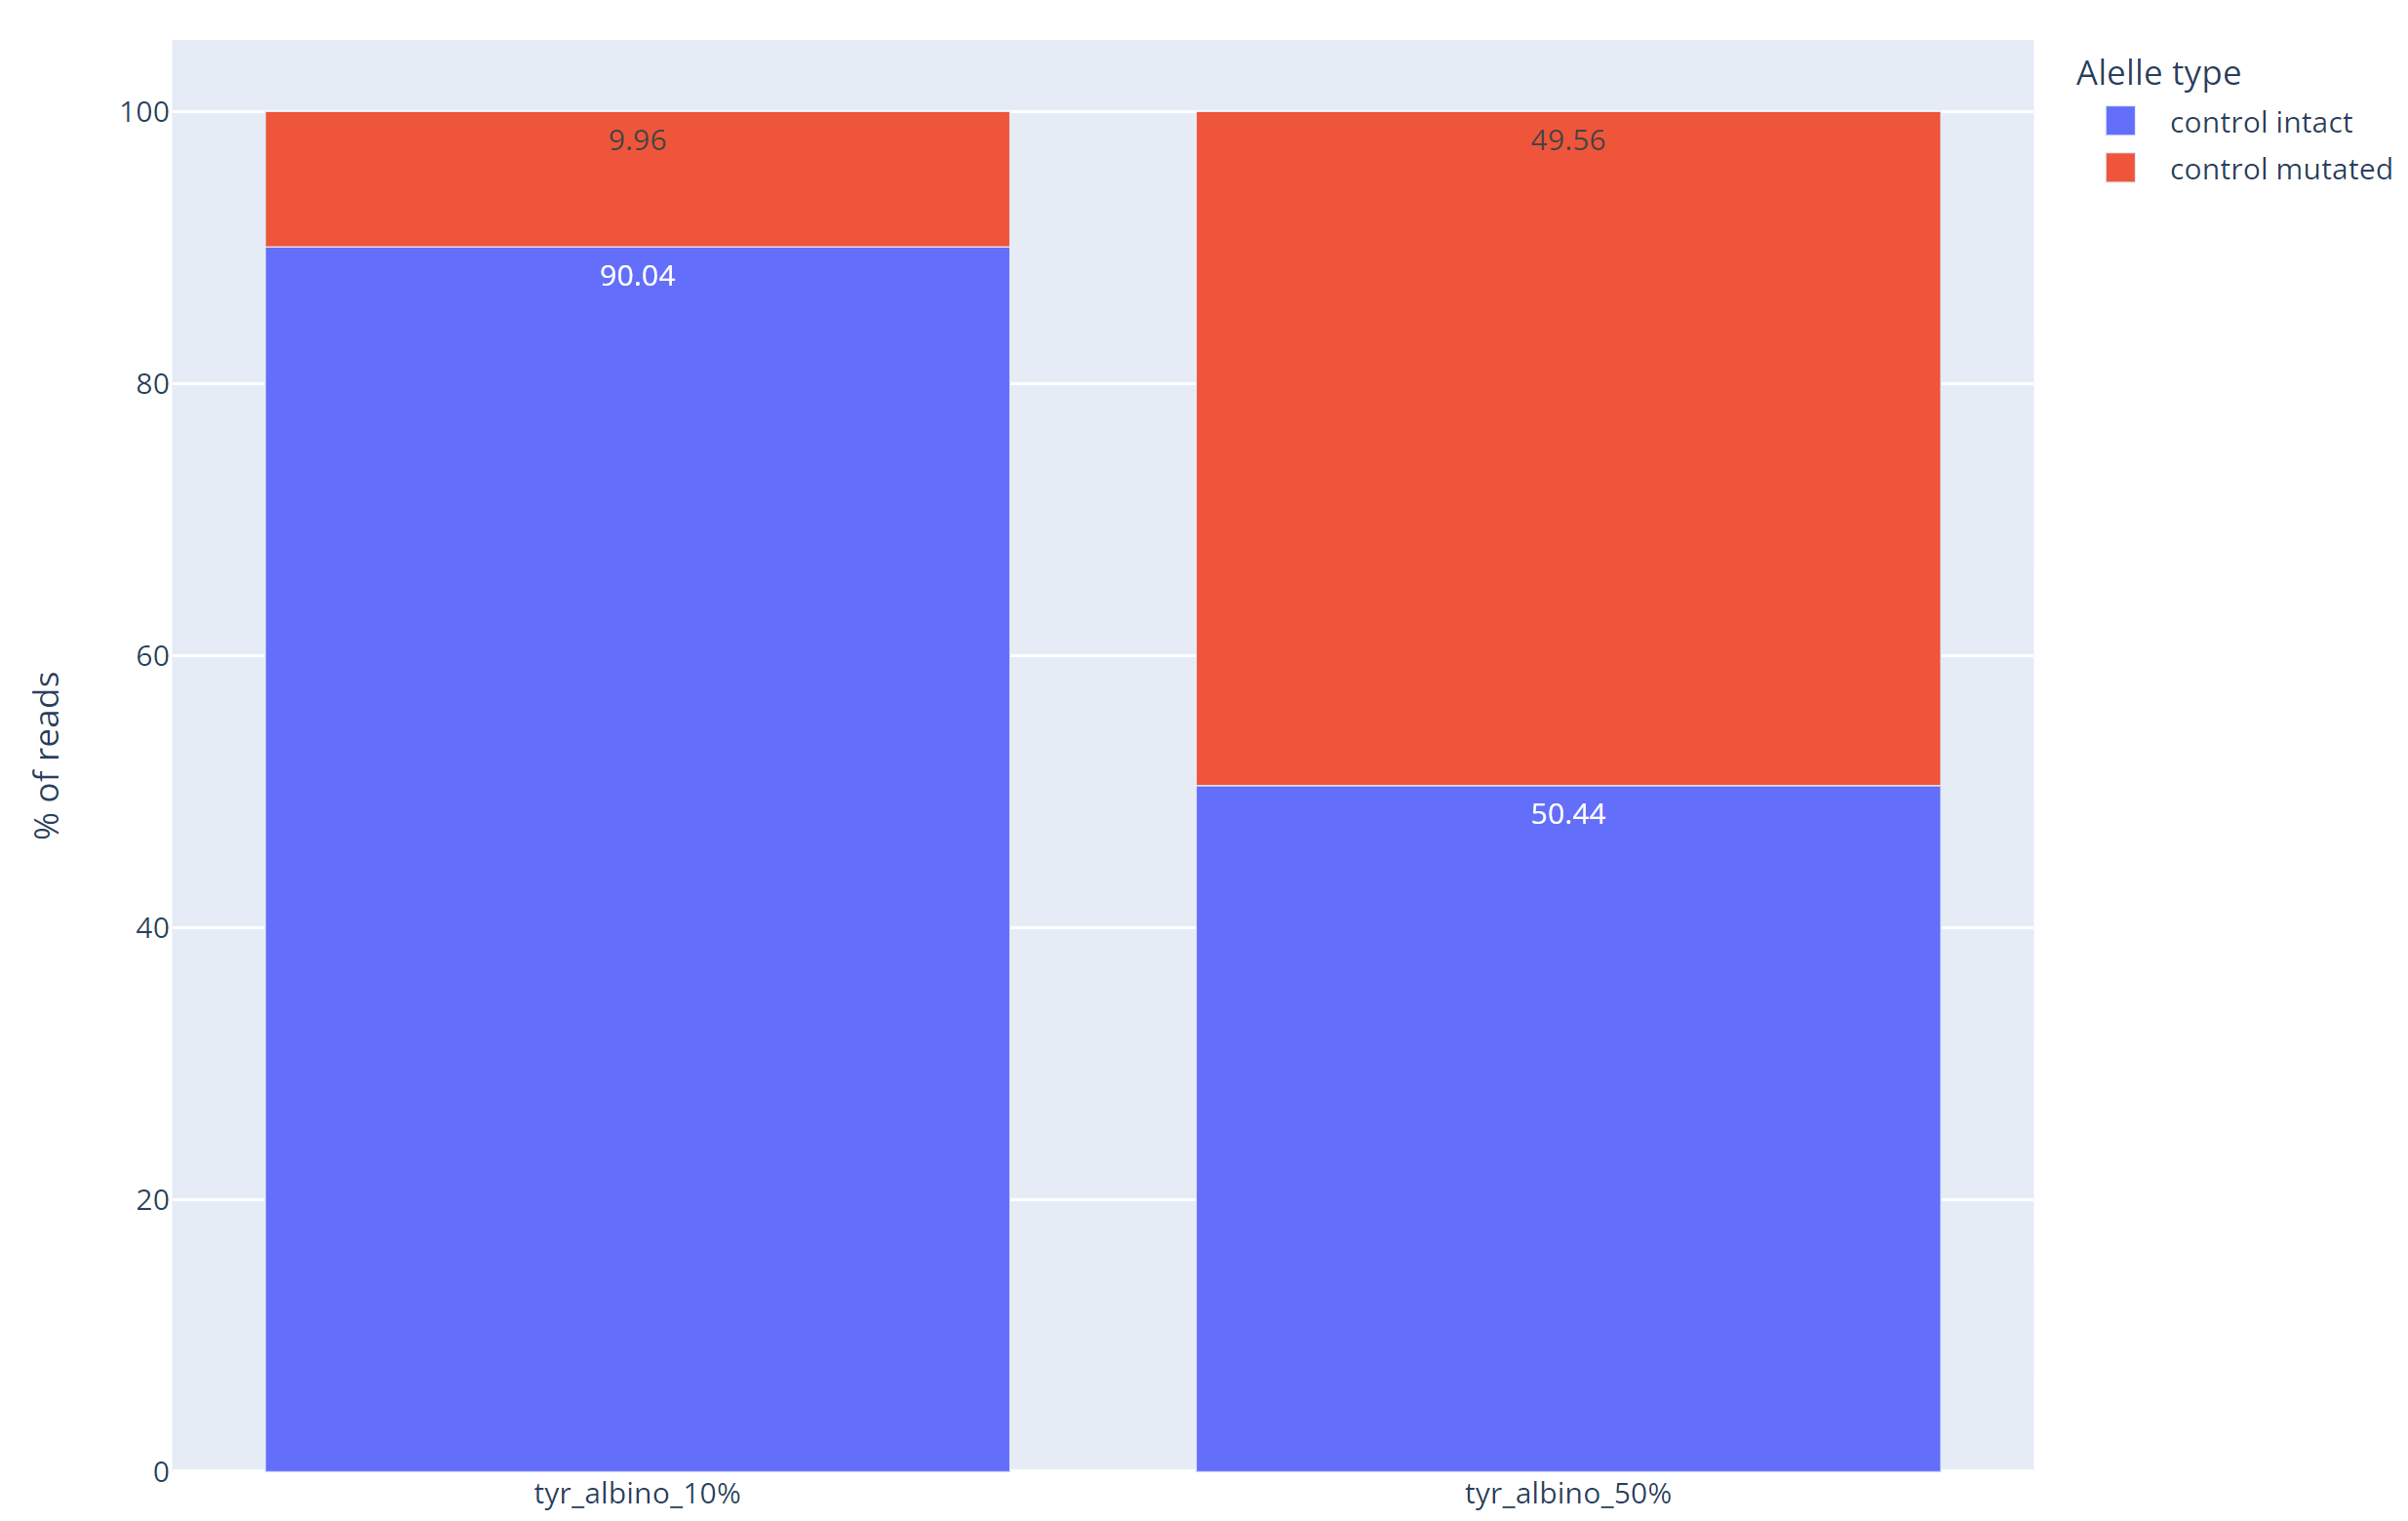

- 最後に、tyr01も含めたBatchを行います

In [55]:
%%bash
# さっそくテスト…
rm -rf DAJINResults/batch_tyr_50_10_01 DAJINResults/.tempdir/batch_tyr_50_10_01
time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_01%.fq.gz is now processing...


Classify...
Clustering...


Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 74, in main
    args.handler(args)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 37, in batchmode
    batch.batch_execute(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/batch.py", line 77, in batch_execute
    core_execute.execute_sample(args)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 134, in execute_sample
    clust_sample = clustering.clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 114, in add_labels
    mutation_score = make_score(cssplits_control, cssplits_sample)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/make_score.py", line 101, in make_score
    percent_control = call_percent(co

CalledProcessError: Command 'b'# \xe3\x81\x95\xe3\x81\xa3\xe3\x81\x9d\xe3\x81\x8f\xe3\x83\x86\xe3\x82\xb9\xe3\x83\x88\xe2\x80\xa6\nrm -rf DAJINResults/batch_tyr_50_10_01 DAJINResults/.tempdir/batch_tyr_50_10_01\ntime DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv\n'' returned non-zero exit status 1.

- なぜかエラーが出ました…
- ちょっと長くなったので、次回に回したいと思います。

# まとめ


- Batchで行うと2回目以降の分類がめちゃくちゃになる問題に取り組みました
- 原因はControlのmidsvが1度目の処理（preprocess.correct_sequence_errorなど）で上書きされていたことでした。
- `shutil.copytree`を使ってmidsv_controlにオリジナルを保存し、サンプルの実行時にはその都度midsv_controlにあるオリジナルをmidsvにコピーして使用する形としました
- うまくいきました

- 一方で、なぜか`tyr_01`がエラーを出したので、次回はこの対策に取り組みます

# 次に取り組むこと

### Lists

+ **tyr_10%, 01%でうまくいかなかった理由を検討する**

+ [ ] 短いリードの扱いをどうするべきか
+ [ ] `SV`の判定をconsensus callのあとにする
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`clustering.replace_both_ends_n`）
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする